In [ ]:
'''
system import
'''
import math
from collections import deque
from datetime import datetime, timedelta
from os import close

'''
stock API import
'''
import tushare as ts


'''
data processing import
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


'''
gymnasium import
'''
import gymnasium
from gymnasium import spaces


'''
pytorch import
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler


'''
ray import
'''
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import EnvContext
from ray.tune.registry import register_env


'''
fix seed
'''
np.random.seed(135)
torch.manual_seed(135)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55

Setup Env

In [ ]:
class PortfolioOptimizationEnv(gymnasium.Env):
    '''
    Environment setting with OpenAI

    Assumptions:
    1. In this case, the team has loose the constrain of 24 hours holding period. Once a person buy in the stock, the person can sell it immediately
    2. We have simplified the buy order mechanism so that stocks can be bought at the closing price of the day in this environment.

    State: A stack of stock price data, stock index data, current stock volums, current cash amount
    Observation: Same with state but in a 365 trading days duration
    Action: A float list with a length of N (number of stocks chosen) which elements are within range (-1,1). When positive -> buy Ni * cash amount of stock i. When negtive -> sell Ni present of stocki's volume

    '''

    def __init__(self,env_config):
        super(PortfolioOptimizationEnv, self).__init__()
        try:
            self.history_length = env_config['history_length']
            self.start = env_config['start']                        #define start date
            self.end = env_config['end']                            #define end date
            self.market = env_config['market']                      #define market -> currently only China
            self.n_stock = env_config['n_stock']                    #define the number of stock chosen
            self.cash = env_config['cash']                          #define the initial cash we take into the market
            self.smoothing_factor = env_config['smoothing_factor']  #define smooth for the DSR reward function

            self.market_data = self.load_market_data(self.start, self.end, self.market)         #Initialize market data during the start to end -> execute once to shorten running time
            self.close_data = self.load_full_close_data(self.start, self.end, self.market)      #Initialize close data

            self.stock_tensor_length = self.market_data.shape[1] - 1                                    #See observation_space
            self.date_list = self.load_trading_days(self.start, self.end, self.market)                  #Filter trading days from the period
            self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_stock,), dtype=np.float32)     #define action space, please see 'Action' in the class comment for detail
            self.observation_space = spaces.Box(                                                        #define observation space as required by Rllib, the observation space have to be a flattened np list
                low=-np.inf, high=np.inf,                                                               #Thus the dimension is calcualted as shape
                shape=(self.history_length * (self.stock_tensor_length + self.n_stock + 1 + self.n_stock + 1),),
                dtype=np.float32
            )

            self.state_buffer = deque(maxlen=self.history_length)           #define state deque
            self.initial_cash = np.float32(self.cash)                       #define cash buffer
            self.stock_volume = np.zeros(self.n_stock, dtype=np.float32)    #define stock volume recorder

            self.A_t = np.float32(0.0)
            self.B_t = np.float32(0.0)
            self.Previous_A_t = np.float32(0.0)
            self.Previous_B_t = np.float32(0.0)                             #define reward parameters
            self.net_price = np.array([], dtype=np.float32)                 #define net price loader
            self.current_step = 0                                           #define step recorder

        except Exception as e:
            print("Error during initialization:", e)
            raise


    def step(self, action):
        '''
        Step function, step forward according to policy model's return
        '''

        self.current_step += 1
        next_date = self.date_list[self.current_step]
        action = self.normalize_action(action)
        reward = self.calculate_reward(action, next_date)

        next_state = self.get_state(self.current_step, action,  reward, next_date)
        stacked_state = np.array(self.state_buffer).flatten().astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)

        done = self.net_price[-1] <= 0
        turncated = self.current_step >= len(self.date_list) - 1
        info = {
                "net_price": self.net_price[-1],  # Pass the current net price
                "cash": self.cash,  # Example: Pass cash if needed
            }

        '''log monitoring -> comment back when needed
        if self.current_step % 100 == 0:
          print('-------------------------------------------------')
          print(f'The net price is: {self.net_price[-1]}')
          print(f'The current step is: {self.current_step}')
          print(f'The cash is :{self.cash}')
          print(f'The stock volume is :{self.stock_volume}')
          print(f'The actions are: {action}')
        '''


        return stacked_state, reward, done, turncated, info




    def reset(self, seed = None, options = None):
        '''
        Reset function, reset the environment when an episode is done
        '''
        if seed is not None:
          np.random.seed(seed)
          torch.manual_seed(seed)
        self.state_buffer = deque(maxlen=self.history_length)
        self.cash = self.initial_cash
        self.stock_volume = np.zeros_like(self.stock_volume)
        self.A_t = np.float32(0.0)
        self.B_t = np.float32(0.0)
        self.Previous_A_t = np.float32(0.0)
        self.Previous_B_t = np.float32(0.0)
        self.net_price = np.zeros(self.history_length, dtype=np.float32)
        self.current_step = self.history_length

        self.date_list = self.load_trading_days(self.start, self.end, self.market)
        first_365_days = self.date_list[:self.history_length]

        for idx, date in enumerate(first_365_days):
            dummy_action = np.zeros(self.action_space.shape, dtype=np.float32)
            dummy_reward = 0.0
            next_state = self.get_state(idx, dummy_action, dummy_reward, date)

        stacked_state = np.array(self.state_buffer).flatten()
        stacked_state = stacked_state.astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)
        return stacked_state, {}




    def get_state(self, idx, action, reward, date):
        '''
        Obtain state and return to step function
        '''
        stock_data_current = self.market_data[self.market_data['trade_date'] == date].iloc[0].drop(['trade_date']).values
        reward_array = np.array([reward], dtype=np.float32)
        net_price_current = np.array([self.net_price[self.current_step-1]], dtype=np.float32)
        full_state = np.concatenate([stock_data_current, action, reward_array, self.stock_volume, net_price_current])
        date_encodings = self.calculate_date_encoding(idx, full_state.shape[0])
        full_state_with_encoding = full_state + date_encodings
        self.state_buffer.append(full_state_with_encoding)
        return full_state_with_encoding



    def load_trading_days(self, start, end, market):
        '''
        Filter trading days
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            trade_cal = pro.trade_cal(exchange = '',start_date = start, end_date = end)
            trade_cal = trade_cal[trade_cal['is_open'] == 1]
            trading_dates = trade_cal['cal_date'].tolist()
            return trading_dates
        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')




    def load_full_close_data(self, start, end, market='CHINA'):
        '''
        Load close price , the close price is loaded separately for calculating cumulative return and net price
        The close price in the "load_market_data" function has been normalized; thus need to load separately
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            df_close = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                df = df[['trade_date', 'close']]
                df_renamed = df.rename(columns={'close': f"close_{code.split('.')[0]}"})

                if df_close.empty:
                    df_close = df_renamed
                else:
                    df_close = pd.merge(df_close, df_renamed, on='trade_date', how='outer')

            df_close.sort_values('trade_date', inplace=True)
            return df_close

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def load_close_data(self, date):
            '''
            Load close price for a specific day
            '''
            data_on_date = self.close_data[self.close_data['trade_date'] == date]
            close_columns = [col for col in data_on_date.columns if 'close_' in col]
            close_array = data_on_date[close_columns].values.flatten().astype(np.float32)
            return close_array



    def load_market_data(self, start, end, market='CHINA'):
        '''
        Load the market data and normalize it
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()

            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            Full_CHINA_STOCK_df = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                adj_factors = pro.adj_factor(ts_code=code, start_date=start, end_date=end)
                daily_basic = pro.daily_basic(ts_code=code, start_date=start, end_date=end)
                daily_basic = daily_basic.drop(columns=['close'])

                df = pd.merge(df, adj_factors[['trade_date', 'adj_factor']], on='trade_date', how='left')
                df['close_adj'] = df['close'] / df['adj_factor']
                df['open_adj'] = df['open'] / df['adj_factor']
                df['high_adj'] = df['high'] / df['adj_factor']
                df['low_adj'] = df['low'] / df['adj_factor']
                df['close_price'] = df['close']
                df = pd.merge(df, daily_basic, on='trade_date', how='left')
                df = df.drop(columns=['adj_factor', 'ts_code_x','ts_code_y','close'])
                df_renamed = df.rename(columns=lambda x: f"{x}_{code.split('.')[0]}" if x != 'trade_date' else x)

                if Full_CHINA_STOCK_df.empty:
                    Full_CHINA_STOCK_df = df_renamed
                else:
                    Full_CHINA_STOCK_df = pd.merge(Full_CHINA_STOCK_df, df_renamed, on='trade_date', how='outer')

            Full_CHINA_STOCK_df.sort_values('trade_date', inplace=True)
            columns_to_normalize = [col for col in Full_CHINA_STOCK_df.columns if col != 'trade_date']
            scaler = MinMaxScaler()
            Full_CHINA_STOCK_df[columns_to_normalize] = scaler.fit_transform(Full_CHINA_STOCK_df[columns_to_normalize])

            return Full_CHINA_STOCK_df

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def calculate_date_encoding(self, idx, embedding_dimension):
        '''
        Add date encoding to the data according to the paper "Attention is all you need" by Vaswani et al.
        But somehow it also works on our value function which is a LSTM setting in this case. Need further investigate

        Also. there are two possible method to implement this embedding, one put it here follow the instruction in 'attention is all you need',
        two you can put it within the model to make it trainable parameters, we will investigate on this
        '''
        encoding = []
        for i in range(embedding_dimension):
            if i % 2 == 0:
                value = np.sin(idx / (10000 ** (i / embedding_dimension)))
            else:
                value = np.cos(idx / (10000 ** (i / embedding_dimension)))
            encoding.append(value)
        return np.array(encoding, dtype=np.float32)




    def calculate_reward(self, action, date):
        '''
        Implement Differencial Sharpe Ratio (DSR) as the reward function to take in consideration of the risk
        '''

        portfolio_return = self.get_portfolio_return(action, date)
        self.Previous_A_t = self.A_t.copy()
        self.Previous_B_t = self.B_t.copy()
        self.A_t = (1 - self.smoothing_factor) * self.A_t + self.smoothing_factor * portfolio_return
        self.B_t = (1 - self.smoothing_factor) * self.B_t + self.smoothing_factor * (portfolio_return ** 2)

        delta_A_t = self.A_t - self.Previous_A_t
        delta_B_t = self.B_t - self.Previous_B_t

        if self.Previous_B_t - (self.Previous_A_t ** 2) > 0:
            denom = (self.Previous_B_t - (self.Previous_A_t ** 2)) ** 1.5
            numer = self.Previous_B_t * delta_A_t - 0.5 * self.Previous_A_t * delta_B_t
            DSR = numer / denom
        else:
            DSR = 0
        return DSR



    def calculate_net_price(self, action, date):
        '''
        Calcualte the net price for a day
        '''
        close_values = self.load_close_data(date)
        for idx, act in enumerate(action):
            if act > 0:
                self.stock_volume[idx] += (self.cash * act) / close_values[idx]
                self.cash -= self.cash * act
            elif act < 0:
                self.cash += (-act) * self.stock_volume[idx] * close_values[idx]
                self.stock_volume[idx] += self.stock_volume[idx] * act
        net_price_value = self.cash + np.sum(self.stock_volume * close_values)
        self.net_price = np.append(self.net_price, net_price_value)
        return net_price_value



    def get_portfolio_return(self, action, date):
        '''
        Calcualte the return for a day
        '''
        current_price = self.calculate_net_price(action, date)
        last_day = self.current_step - 2
        previous_price = self.net_price[last_day]
        return np.float32(current_price - previous_price)



    def normalize_action(self, action):
        '''
        Since the positive action sampled from the policy model does not always sum up to 1 which represent over 100% of the cash, thus we needs to normalize it
        '''
        positive_mask = (action >= 0).astype(np.float32)
        positive_action = action * positive_mask
        positive_sum = np.sum(positive_action)
        if positive_sum > 1:
            positive_action = positive_action / positive_sum
        action = action * (1 - positive_mask) + positive_action

        for i, a in enumerate(action):
            if a < 0:
              if self.stock_volume[i] > 0:
                continue
              else:
                action[i] = 0
        return action


Build Transformer Actor and Critic

In [ ]:

#Code Reference: University of Toronto ECE1786 Assignment3 Author: Jonathan Rose
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """


    def __init__(self, model_config):
        super().__init__()
        assert model_config['n_embd'] % model_config['n_head'] == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(model_config['n_embd'], 3 * model_config['n_embd'])
        # output projection
        self.c_proj = nn.Linear(model_config['n_embd'], model_config['n_embd'])
        # regularization
        self.attn_dropout = nn.Dropout(model_config['attn_pdrop'])
        self.resid_dropout = nn.Dropout(model_config['resid_pdrop'])
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(model_config['block_size'], model_config['block_size']))
                                     .view(1, 1, model_config['block_size'], model_config['block_size']))
        self.n_head = model_config['n_head']
        self.n_embd = model_config['n_embd']



    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y



class Block(nn.Module):
    """ an unassuming Transformer block """
    def __init__(self, model_config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(model_config['n_embd'])
        self.attn = CausalSelfAttention(model_config)
        self.ln_2 = nn.LayerNorm(model_config['n_embd'])
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(model_config['n_embd'], 4 * model_config['n_embd']),
            c_proj  = nn.Linear(4 * model_config['n_embd'], model_config['n_embd']),
            act     = NewGELU(),
            dropout = nn.Dropout(model_config['resid_pdrop']),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward



    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x



# This actor model is responsible for choosing the actions for cash allocation
class CustomActorCriticModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        custom_model_config = model_config['custom_model_config']
        self.n_embd = custom_model_config['n_embd']
        self.n_layer = custom_model_config['n_layer']
        self.n_head = custom_model_config['n_head']
        self.block_size = custom_model_config['block_size']
        self.embd_pdrop = custom_model_config['embd_pdrop']
        self.resid_pdrop = custom_model_config['resid_pdrop']
        self.attn_pdrop = custom_model_config['attn_pdrop']

        self.transformer = nn.ModuleDict({
            'drop': nn.Dropout(self.embd_pdrop),
            'h': nn.ModuleList([Block(custom_model_config) for _ in range(self.n_layer)]),
            'ln_f': nn.LayerNorm(self.n_embd),
        })

        self.policy_head = nn.Linear(self.n_embd, num_outputs)
        self.value_head = nn.Linear(self.n_embd, 1)
        self.apply(self._init_weights)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)



    def forward(self, input_dict, state, seq_lens):

        if isinstance(input_dict['obs'], np.ndarray):
            obs = torch.tensor(input_dict['obs'], dtype=torch.float32).to(self.device)
        else:
            obs = input_dict['obs'].to(self.device)

        batch_size = obs.size(0)
        orig = obs.size(1)
        obs = obs.view(batch_size, orig//self.n_embd, self.n_embd )
        x = self.transformer.drop(obs)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        last_hidden_state = x[:, -1, :]

        policy = self.policy_head(last_hidden_state)
        value = self.value_head(last_hidden_state)
        self._value_out = self.value_head(last_hidden_state).squeeze(-1)
        return policy, state

    def value_function(self):
        return self._value_out

ModelCatalog.register_custom_model('custom_actor_critic_model',CustomActorCriticModel)

In [ ]:
class CustomMetricsCallback(DefaultCallbacks):
    '''
    Custom call back class to monitor the net price
    '''
    def on_episode_end(self, *, worker, base_env, policies, episode, **kwargs):
        #print(f"The episode is {episode}")
        env = base_env.get_sub_environments()[0]
        final_net_price = env.net_price[-1] if len(env.net_price) > 0 else None
        if final_net_price is not None:
            episode.custom_metrics["final_net_price"] = final_net_price


In [ ]:
config = {
    'env': 'my_portfolio_env',
    'num_workers': 0,
    'num_gpus': 1,
    'framework': 'torch',
    'env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20210101',
        'end': '20230631',
        'smoothing_factor': 0.1
    },
    'val_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20230701',
        'end': '20231231',
        'smoothing_factor': 0.1
    },
    'test_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20240101',
        'end': '20241123',
        'smoothing_factor': 0.1
    },
    'model': {
        'custom_model': 'custom_actor_critic_model',
        'custom_action_dist': None,
        'vf_share_layers': True,
        'custom_model_config': {
            'n_embd': 152,
            'n_layer': 8,
            'n_head': 19,
            'block_size': 1024,
            'embd_pdrop': 0.1,
            'resid_pdrop': 0.1,
            'attn_pdrop': 0.1
        }
    },

    'lr': 5e-3, #change 4
    'train_batch_size': 512,
    'sgd_minibatch_size': 64,
    'num_epochs': 100,
    'callbacks': CustomMetricsCallback,
}

In [ ]:

ray.init(ignore_reinit_error=True)

def env_creator(env_config):
    return PortfolioOptimizationEnv(env_config)

register_env('my_portfolio_env', env_creator)


algo = (
    PPOConfig()
    .environment('my_portfolio_env', env_config=config['env_config'])
    .framework('torch')
    .resources(num_gpus=1)
    .env_runners(num_env_runners=config['num_workers'])
    .training(
        model=config['model'],
        lr=config['lr'],
        train_batch_size=config['train_batch_size'],
        num_epochs=config['num_epochs']
    )
    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False
    )
    .rollouts(sample_timeout_s=300)
    .callbacks(CustomMetricsCallback)
    .build()
)

num_epochs = 50
epoch_net_values = []
epoch_policy_loss = []
epoch_value_loss = []

for i in range(num_epochs):
    print(f"Training iteration {i}")
    result = algo.train()



2024-11-26 02:29:25,060	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-11-26 02:29:26,293	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-11-26 02:29:41,307	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-26 02:29:46,890	INFO trainable.py:161 -- Trainable.setup took 20.574 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-26 02:29:46,892	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0


2024-11-26 02:29:57,737	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Training iteration 5
Training iteration 6
Training iteration 7
Training iteration 8
Training iteration 9
Training iteration 10
Training iteration 11
Training iteration 12
Training iteration 13
Training iteration 14
Training iteration 15
Training iteration 16
Training iteration 17
Training iteration 18
Training iteration 19
Training iteration 20
Training iteration 21
Training iteration 22
Training iteration 23
Training iteration 24
Training iteration 25
Training iteration 26
Training iteration 27
Training iteration 28
Training iteration 29
Training iteration 30
Training iteration 31
Training iteration 32
Training iteration 33
Training iteration 34
Training iteration 35
Training iteration 36
Training iteration 37
Training iteration 38
Training iteration 39
Training iteration 40
Training iteration 41
Training iteration 42
Training iteration 43
Training iteration 44
Training iteration 45
Training iteration 

Save the testing result

In [ ]:
eval_rewards = {}
eval_net_prices = {}

def evaluate(trainer, env, num_episodes=10):
    all_rewards = []
    net_prices = []
    episode_reward = 0
    done = False
    truncated = False
    obs = env.reset()

    while not done and not truncated:
        if isinstance(obs, tuple):
            obs_input = obs[0]
        elif isinstance(obs, dict):
            obs_input = obs["obs"]
        else:
            obs_input = obs

        action = trainer.compute_single_action(obs_input, explore=False)
        obs, reward, done, truncated, info = env.step(action)
        all_rewards.append(reward)
        net_price = env.net_price[-1]
        net_prices.append(net_price)

    return all_rewards, net_prices

evaluation_env = PortfolioOptimizationEnv(config['test_env_config'])
all_rewards, net_prices = evaluate(algo, evaluation_env)
evaluation_env.close()

eval_rewards['Transformer'] = all_rewards
eval_net_prices['Transformer'] = net_prices
print(f"Evaluation rewards: {all_rewards}")
print(f"Evaluation net prices: {net_prices}")


rewards_data = []
for model, rewards in eval_rewards.items():
    for day, value in enumerate(rewards, start=1):
        rewards_data.append({
            "Model Type": model,
            "Day Number": day,
            "Value": value
        })
rewards_df = pd.DataFrame(rewards_data)

net_prices_data = []
for model, net_prices in eval_net_prices.items():
    for day, value in enumerate(net_prices, start=1):
        net_prices_data.append({
            "Model Type": model,
            "Day Number": day,
            "Value": value
        })
net_prices_df = pd.DataFrame(net_prices_data)


from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIE1666\ Project/MIE1666\ Code/final_comparsion
rewards_csv_path = "eval_rewards_transformer.csv"
net_prices_csv_path = "eval_net_transformer.csv"
rewards_df.to_csv(rewards_csv_path, index=False)
net_prices_df.to_csv(net_prices_csv_path, index=False)

Evaluation rewards: [0, -0.020389249403324823, -0.019425412834844155, -0.014443765144711926, -0.014605449748435756, -0.01715613293234715, -0.013439818286153524, -0.007122121165685412, -0.006177435837938998, -0.011605790129917243, -0.008544923499657308, -0.0020793309142810327, -0.015513086927900436, -0.009786971780311916, -0.004733161761679604, -0.012028719440362759, -0.005477551557997341, -0.006413781547911079, -0.00031092391253071896, -0.0018793009864569426, -0.004864486327815897, -0.016692675740103156, 0.002818224080294118, 0.0015745598469175312, -0.0074566276950839595, -0.01689573997318372, -0.0017653690791697796, -0.023775317656429235, -0.02228810320710636, -0.0003406382760512529, 0.007177901928381903, -0.004103146308319545, -0.014299722698378677, 0.0029107434585692125, 0.004856149794480183, -0.00861350691181713, 0.0017538562271982644, -0.012418531827763521, -0.010212865909752525, 0.02240451147948992, -0.013395752131924954, 0.008328583883453153, -0.012684324280325853, 0.03574715692

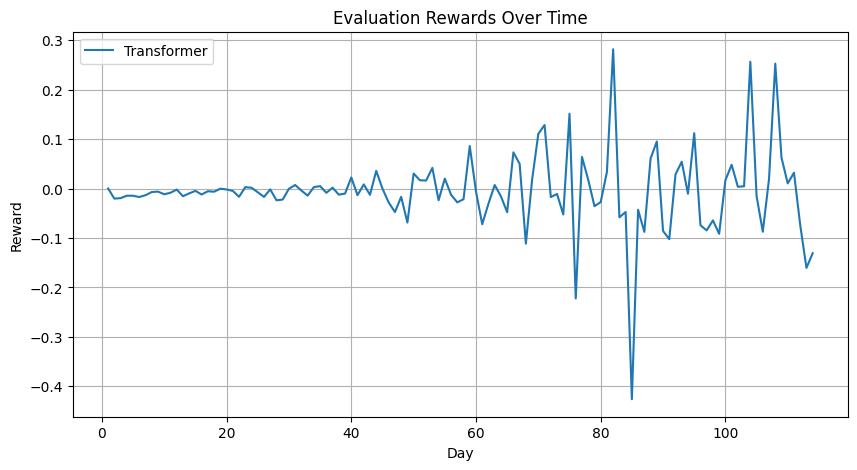

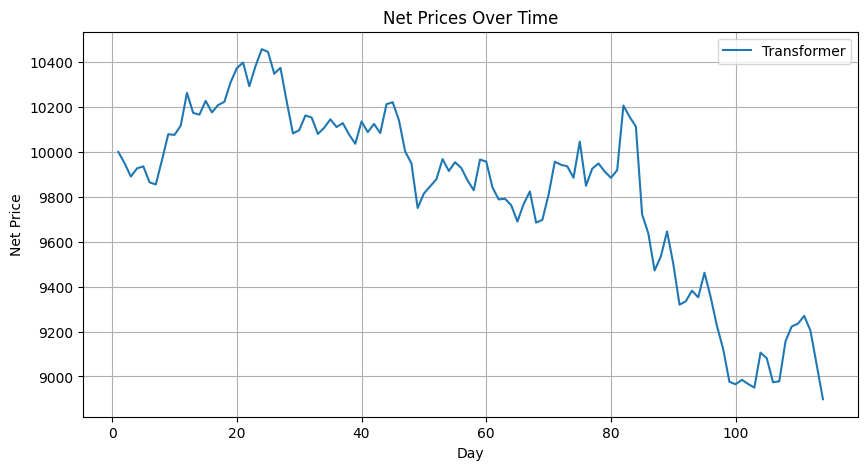

In [ ]:
plt.figure(figsize=(10, 5))
for model, rewards in eval_rewards.items():
    days = range(1, len(rewards) + 1)
    plt.plot(days, rewards, label=model)
plt.xlabel('Day')
plt.ylabel('Reward')
plt.title('Evaluation Rewards Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for model, net_prices in eval_net_prices.items():
    days = range(1, len(net_prices) + 1)
    plt.plot(days, net_prices, label=model)
plt.xlabel('Day')
plt.ylabel('Net Price')
plt.title('Net Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [ ]:
checkpoint_path = algo.save()
print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpfvkan301), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 11363.025732319056, 'cur_lr': 0.004999999999999999, 'total_loss': 86866.47065795898, 'policy_loss': 0.21692000090377406, 'vf_loss': 0.19346662053838373, 'vf_explained_var': -0.12989822074770926, 'kl': 7.644624291062355, 'entropy': 17.102832894325257, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 19800.5, 'diff_num_grad_updates_vs_sampler_policy': 199.5}}, 'num_env_steps_sampled': 25600, 'num_env_steps_trained': 25600, 'num_agent_steps_sampled': 25600, 'num_agent_steps_trained': 25600}, 'env_runners': {'episode_reward_max': 0.08120890558141981, 'episode_reward_min': -2.7506763459915784, 'episode_reward_mean': -1.061590729470588, 'episode_len_mean': 502.0, 'episode_media': {}, 'episodes_timesteps_total': 25100, 'policy_reward